In [307]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, collections, operator
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import scipy.stats as stats

In [308]:
# load dataframe
book_df = pd.read_pickle("data/book_data_final.pkl")
book_df.describe()

,index,book_num,followers,pub_date,og_pub_date,avg_rating,pages,perc_like,trivia,quote_likes,rev_likes,num_revs,num_ratings,kindle_price,amzn_price,total_added,total_to_read,avg_added,avg_to_read
count,1801.000000,1.801000e+03,1801.000000,1543.000000,755.000000,1801.000000,1444.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1.801000e+03,51.000000,124.000000,1.801000e+03,1.801000e+03,1801.000000,1801.000000
mean,900.000000,3.811812e+06,1019.981677,1995.296176,1984.888742,2.589217,257.235457,60.336480,0.160466,59.436979,10.702943,255.372571,8.434409e+03,14.929412,27.828065,1.197064e+04,2.807591e+03,4.156541,1.485003
std,520.048235,2.519350e+06,8910.677652,30.641558,39.391301,1.875735,246.956128,44.629923,4.272303,697.269675,66.612962,3249.339889,1.332274e+05,31.227801,69.360752,1.757196e+05,3.586473e+04,57.492032,19.021566
min,0.000000,5.289000e+03,0.000000,1010.000000,1601.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.490000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,450.000000,1.601232e+06,0.000000,1991.000000,1983.000000,0.000000,124.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,4.990000,6.252500,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,900.000000,3.515853e+06,1.000000,2000.000000,1996.000000,3.540000,224.000000,88.000000,0.000000,0.000000,0.000000,0.000000,3.000000e+00,8.310000,11.365000,8.000000e+00,4.000000e+00,0.000000,0.000000
75%,1350.000000,6.113094e+06,19.000000,2006.000000,2004.000000,4.000000,328.000000,100.000000,0.000000,0.000000,1.000000,4.000000,3.900000e+01,11.490000,25.707500,1.100000e+02,4.000000e+01,0.040936,0.023392
max,1800.000000,8.625407e+06,276972.000000,2019.000000,2010.000000,5.000000,3604.000000,100.000000,169.000000,15776.000000,1206.000000,98898.000000,4.510958e+06,209.220000,722.320000,5.391634e+06,1.082134e+06,1817.988304,627.883041


In [309]:
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801 entries, 0 to 1800
Data columns (total 24 columns):
index            1801 non-null int64
book_num         1801 non-null int64
title            1801 non-null object
author           1801 non-null object
followers        1801 non-null int64
pub_date         1543 non-null float64
og_pub_date      755 non-null float64
avg_rating       1801 non-null float64
genre            1784 non-null object
binding          1801 non-null object
pages            1444 non-null float64
language         1799 non-null object
perc_like        1801 non-null int64
trivia           1801 non-null int64
quote_likes      1801 non-null int64
rev_likes        1801 non-null int64
num_revs         1801 non-null int64
num_ratings      1801 non-null int64
kindle_price     51 non-null float64
amzn_price       124 non-null float64
total_added      1801 non-null int64
total_to_read    1801 non-null int64
avg_added        1801 non-null float64
avg_to_read      1801 non-n

In [310]:
# sns.pairplot(book_df.drop(['book_num'], axis=1));

In [311]:
# filter out unknowns and bad columns
mask = ((book_df.title != 'Unknown') & (book_df.author != 'Unknown'))
book_df = book_df[mask].drop(['kindle_price', 'amzn_price', 'index'], axis=1)
book_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1790 entries, 0 to 1800
Data columns (total 21 columns):
book_num         1790 non-null int64
title            1790 non-null object
author           1790 non-null object
followers        1790 non-null int64
pub_date         1541 non-null float64
og_pub_date      755 non-null float64
avg_rating       1790 non-null float64
genre            1773 non-null object
binding          1790 non-null object
pages            1443 non-null float64
language         1788 non-null object
perc_like        1790 non-null int64
trivia           1790 non-null int64
quote_likes      1790 non-null int64
rev_likes        1790 non-null int64
num_revs         1790 non-null int64
num_ratings      1790 non-null int64
total_added      1790 non-null int64
total_to_read    1790 non-null int64
avg_added        1790 non-null float64
avg_to_read      1790 non-null float64
dtypes: float64(6), int64(10), object(5)
memory usage: 307.7+ KB


In [313]:
book_df.binding = book_df.binding\
.replace(['Kindle Edition', 'e book', 'Nook'], 'ebook')\
.replace('Mass Market Paperback', 'Paperback')\
.replace(['Audiobook', 'Audio CD', 'Audio Cassette'], 'Audio')

binding_count = book_df.binding.value_counts()
other = list(binding_count[binding_count <= 8].index)
book_df.binding = book_df.binding.replace(other, 'Other')

book_df.binding.value_counts()

Paperback          765
Hardcover          582
Unknown Binding    294
ebook               69
Other               44
Audio               36
Name: binding, dtype: int64

In [286]:
genre_count = book_df.genre.value_counts()
other = list(genre_count[genre_count <= 10].index)

book_df.genre = book_df.genre.replace(other, 'Other')
book_df.genre.value_counts()

Unknown            1132
Other               220
Fiction              54
Nonfiction           48
Mystery              42
History              41
Childrens            36
Fantasy              26
Classics             23
Romance              20
Historical           19
Sequential Art       17
Science              17
Biography            15
Religion             15
Art                  14
Poetry               12
Science Fiction      11
Philosophy           11
Name: genre, dtype: int64

In [287]:
lang_count = book_df.language.value_counts()
other = list(lang_count[lang_count < 4].index)

book_df.language = book_df.language.replace(other, 'Other')
book_df.language.value_counts()

English       1182
Unknown        449
Spanish         49
German          32
French          25
Other           13
Italian          8
Indonesian       8
Portuguese       5
Polish           5
Arabic           4
Dutch            4
Japanese         4
Name: language, dtype: int64

In [341]:
book_df.sort_values(by='total_to_read', ascending=False).head()

,book_num,title,author,followers,pub_date,og_pub_date,avg_rating,genre,binding,pages,...,perc_like,trivia,quote_likes,rev_likes,num_revs,num_ratings,total_added,total_to_read,avg_added,avg_to_read
18,1592409,Senkyūhyakuhachijūyonen,George Orwell,30197,NaN,NaN,4.17,NaN,Unknown Binding,NaN,...,94,0,13078,1190,60040,2692663,4139645,1082134,1817.988304,627.883041
259,69438,Crepúsculo,Stephenie Meyer,58712,2006.0,2005.0,3.59,NaN,Paperback,512.0,...,78,0,10198,965,98898,4510958,5391634,634932,1196.836257,258.251462
1540,5802013,A Tale of Two Cities,Charles Dickens,21408,2008.0,1859.0,3.83,Classics,Paperback,404.0,...,88,169,2727,675,15778,756962,1385416,502501,382.976608,189.625731
48,7801326,El dador de recuerdos,Lois Lowry,16518,2010.0,1993.0,4.12,NaN,Hardcover,240.0,...,94,0,5119,1206,61522,1573319,2212217,431672,706.947368,175.543860
1155,1057993,Crime and Punishment,Fyodor Dostoyevsky,31233,1981.0,1866.0,4.21,NaN,Paperback,472.0,...,94,0,6160,711,16232,552376,65053,410809,459.777778,219.988304


In [289]:
# log processing number of likes of top quote
book_df['log_quote_likes'] = book_df.quote_likes.apply(lambda x: np.log1p(x))

In [290]:
# clear NaNs
book_df.og_pub_date = book_df.og_pub_date.fillna(book_df.pub_date)
book_df = book_df.dropna(subset=['pub_date'])
book_df.genre = book_df.genre.fillna('Unknown')
book_df.pages = book_df.pages.fillna(book_df.pages.mean())
book_df.language = book_df.language.fillna('Unknown')
book_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1541 entries, 0 to 1800
Data columns (total 22 columns):
book_num           1541 non-null int64
title              1541 non-null object
author             1541 non-null object
followers          1541 non-null int64
pub_date           1541 non-null float64
og_pub_date        1541 non-null float64
avg_rating         1541 non-null float64
genre              1541 non-null object
binding            1541 non-null object
pages              1541 non-null float64
language           1541 non-null object
perc_like          1541 non-null int64
trivia             1541 non-null int64
quote_likes        1541 non-null int64
rev_likes          1541 non-null int64
num_revs           1541 non-null int64
num_ratings        1541 non-null int64
total_added        1541 non-null int64
total_to_read      1541 non-null int64
avg_added          1541 non-null float64
avg_to_read        1541 non-null float64
log_quote_likes    1541 non-null float64
dtypes: float64(

In [291]:
# create age feature
book_df['age'] = book_df.pub_date - book_df.og_pub_date

In [292]:
# select features and create train/test split
feature_select = ['total_added', 'avg_added', 'followers', 'pages',
                  'log_quote_likes', 'rev_likes', 'num_ratings',
                   'num_revs', 'trivia', 'age', 'perc_like']

remainder = book_df.columns.drop(feature_select)
target = book_df.total_to_read 
features = book_df[feature_select]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
'Unused features are:', [feature for feature in remainder]

('Unused features are:',
 ['book_num',
  'title',
  'author',
  'pub_date',
  'og_pub_date',
  'avg_rating',
  'genre',
  'binding',
  'language',
  'quote_likes',
  'total_to_read',
  'avg_to_read'])

In [303]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print('Linear Model Test Score:', lm.score(X_test, y_test)) # score on test data

Linear Model Test Score: 0.6758949500546843


In [304]:
print('Linear Model Train Score:', lm.score(X_train, y_train)) # score on training data

Linear Model Train Score: 0.960086037687212


In [296]:
# create KFold object and cross-validate model
kf = KFold(n_splits=5, shuffle=True, random_state = 420)
scores = cross_val_score(lm, features, target, cv=kf, scoring='r2')
print('Linear Model Average 5-Fold CV Score:',np.mean(scores))

Linear Model Average 5-Fold CV Score: 0.4419636277254657


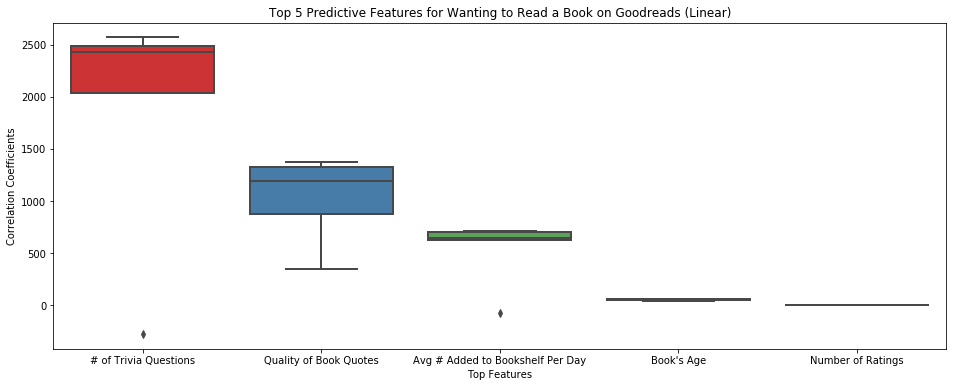

In [340]:
# plot feature coefficient variance
cv_results = cross_validate(lm, X_train, y_train, cv=5, return_estimator=True)

feat_coef = []
for model in cv_results['estimator']:
    feat_coef.append(list(zip(X_train.columns, model.coef_)))
flat_feat = [item for sublist in feat_coef for item in sublist]

d = defaultdict(list)
for k, v in flat_feat:
    d[k].append(v)
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
x = [feat[0] for feat in sorted_d[:5]]
y = [coef[1] for coef in sorted_d[:5]]

plt.figure(figsize=(16, 6))
ax = sns.boxplot(x,y, linewidth=2, palette='Set1')
ax.set_title('Top 5 Predictive Features for Wanting to Read a Book on Goodreads (Linear)')
ax.set_xlabel('Top Features')
ax.set_ylabel('Correlation Coefficients')
ax.set(xticklabels=['# of Trivia Questions', 'Quality of Book Quotes', 'Avg # Added to Bookshelf Per Day', 'Book\'s Age', 'Number of Ratings']);

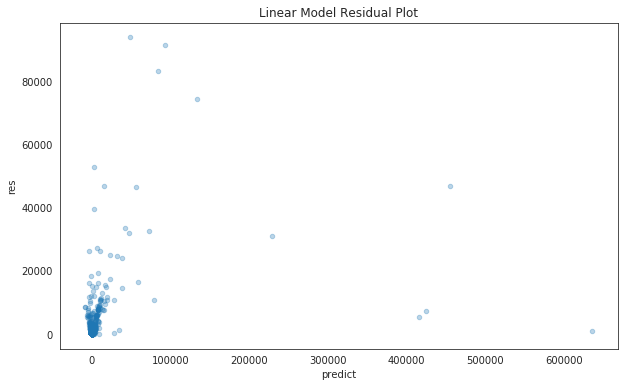

In [298]:
# residual plot
book_df['predict'] = lm.predict(features)
book_df['res'] = abs(book_df.predict - target)

with sns.axes_style('white'):
    plot=book_df.plot(kind='scatter',
                  x='predict',y='res',alpha=0.3,figsize=(10,6))
plt.title('Linear Model Residual Plot');

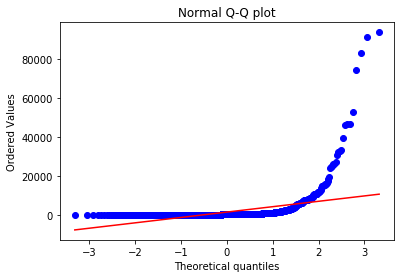

In [299]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(book_df['res'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [342]:
# scale and generate polynomial features for regularization
std = StandardScaler()
X_tr = std.fit_transform(X_train.values)
X_te = std.transform(X_test.values)
feat_transform = std.transform(features)
p = PolynomialFeatures(degree=2)
X_train_poly = p.fit_transform(X_tr)
feat_poly = p.transform(feat_transform)

lasso = Lasso(tol=0.1, alpha=0.01)
lasso_fit = lasso.fit(X_train_poly, y_train)

lasso_scores = cross_val_score(lasso_fit, feat_poly, target, cv=kf, scoring='r2')
print('Lasso Model Average 5-Fold CV Score::', np.mean(lasso_scores))

Lasso Model Average 5-Fold CV Score:: 0.6581947102005729


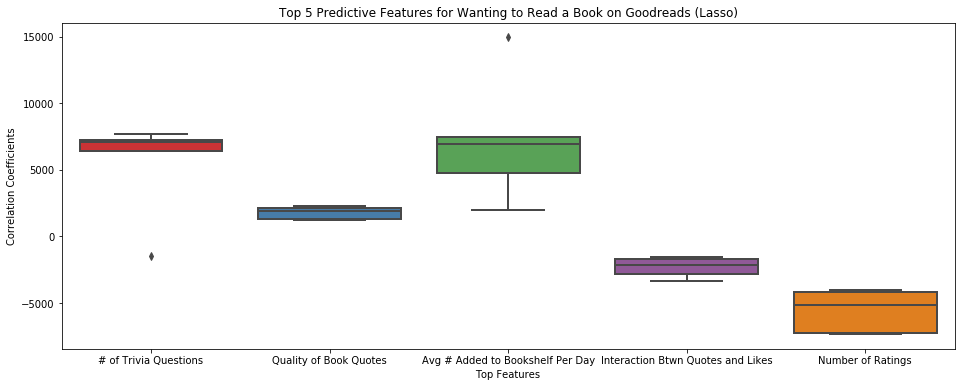

In [339]:
# plot feature coefficient variance
cv_results = cross_validate(lasso, X_train_poly, y_train, cv=5, return_estimator=True)

feat_coef_lasso = []
for model in cv_results['estimator']:
    feat_coef_lasso.append(list(zip(p.get_feature_names(features.columns), model.coef_)))
flat_feat_lasso = [item for sublist in feat_coef_lasso for item in sublist]

d_lasso = defaultdict(list)
for k, v in flat_feat_lasso:
    d_lasso[k].append(v)
sorted_d_lasso = sorted(d_lasso.items(), key=operator.itemgetter(1), reverse=True)
x = [feat[0] for feat in sorted_d_lasso[1:4]] + [feat[0] for feat in sorted_d_lasso[-2:]]
y = [coef[1] for coef in sorted_d_lasso[1:4]] + [feat[1] for feat in sorted_d_lasso[-2:]]

plt.figure(figsize=(16, 6))
ax = sns.boxplot(x,y, linewidth=2, palette='Set1')
ax.set_title('Top 5 Predictive Features for Wanting to Read a Book on Goodreads (Lasso)')
ax.set_xlabel('Top Features')
ax.set_ylabel('Correlation Coefficients')
ax.set(xticklabels=['# of Trivia Questions', 'Quality of Book Quotes', 'Avg # Added to Bookshelf Per Day', 'Interaction Btwn Quotes and Likes', 'Number of Ratings']);

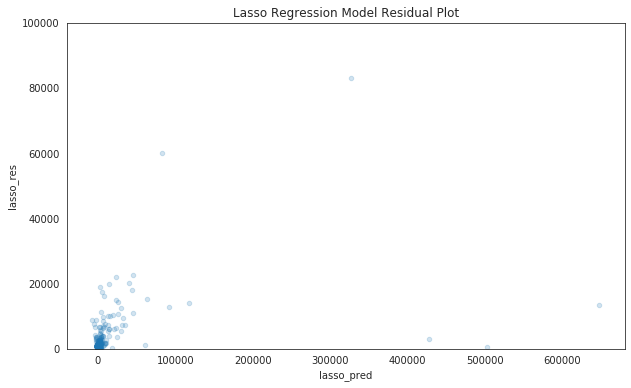

In [305]:
# residual plot
book_df['lasso_pred'] = lasso_fit.predict(p.transform(feat_transform))
book_df['lasso_res'] = abs(book_df.lasso_pred - target)

with sns.axes_style('white'):
    plot=book_df.plot(kind='scatter',
                  x='lasso_pred',y='lasso_res',alpha=0.2,figsize=(10,6), ylim=(0,1e5))
plt.title('Lasso Regression Model Residual Plot');

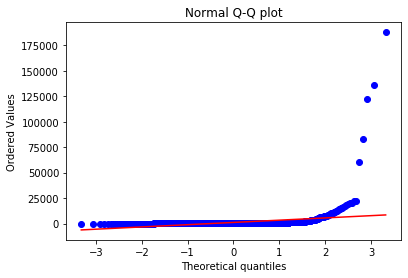

In [302]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(book_df['lasso_res'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()